In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data, wb
import scipy.optimize as sco
import scipy.interpolate as itp

In [2]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
symbols = ['ASNA', 'PTN', 'RHT', 'SNX']
noa = len(symbols)

In [4]:
from datetime import datetime, timedelta
N = 200
days_ago_N = datetime.now() - timedelta(days=N)
days_ago_N_string = days_ago_N.strftime('%Y-%m-%d')

In [5]:
%%time
df = pd.DataFrame()
start = days_ago_N_string
for symbol in symbols:
    print(symbol)
    df[symbol] = data.DataReader(symbol, 'yahoo', start)['Close']

ASNA
PTN
RHT
SNX
CPU times: user 540 ms, sys: 32 ms, total: 572 ms
Wall time: 8.75 s


In [6]:
df.head()

,ASNA,PTN,RHT,SNX
Date,,,,
2017-03-09,4.25,0.35,81.559998,116.199997
2017-03-10,4.21,0.34,82.209999,116.949997
2017-03-13,4.07,0.34,82.879997,117.419998
2017-03-14,4.09,0.34,82.580002,117.230003
2017-03-15,4.08,0.34,83.269997,119.760002


/home/blai/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


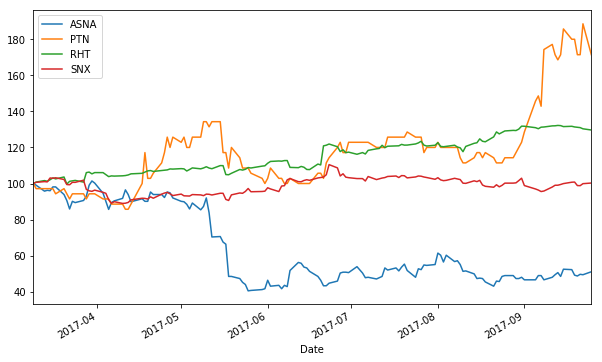

In [7]:
(df / df.ix[0] * 100).plot(figsize=(10,6))

In [8]:
rets = np.log(df / df.shift(1))

In [9]:
rets.mean() * 252

ASNA   -1.227481
PTN     0.984254
RHT     0.474479
SNX     0.004708
dtype: float64

In [10]:
rets.cov() * 252

,ASNA,PTN,RHT,SNX
ASNA,0.730057,0.059779,-0.016583,0.019602
PTN,0.059779,0.495949,-0.001408,0.025512
RHT,-0.016583,-0.001408,0.046250,0.012898
SNX,0.019602,0.025512,0.012898,0.052371


In [11]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.12792216,  0.33175866,  0.44311412,  0.09720505])

In [12]:
np.dot(weights.T, rets.mean()) * 252

0.38021878364376749

In [13]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.082132851730615727

In [14]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.28658829656951401

In [15]:
prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights = weights / np.sum(weights)
    prets.append(np.dot(weights.T, rets.mean() * 252))
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

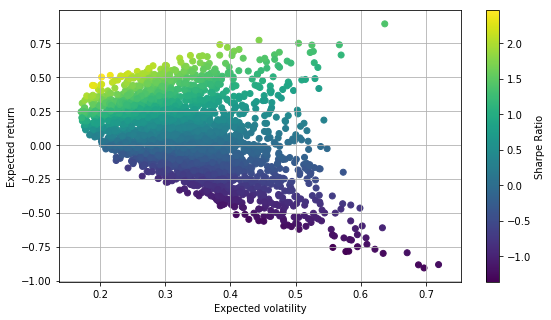

In [16]:
plt.figure(figsize=(9, 5))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe Ratio')

In [17]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.dot(weights.T, rets.mean() * 252)
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [18]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [19]:
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(noa))

In [20]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 42.6 ms


In [21]:
opts

     fun: -2.622780318747801
     jac: array([  5.53385425e+00,   1.30444765e-04,  -2.54213810e-05,
         8.45485985e-01])
 message: 'Optimization terminated successfully.'
    nfev: 55
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([  3.75586748e-15,   1.63280657e-01,   8.36719343e-01,
         0.00000000e+00])

In [22]:
def calc_weights(BP, xs, df):
    t = BP / np.dot(df.tail(1), xs)
    print t * xs
    print symbols

In [23]:
calc_weights(213, opts.x, df)

[  9.03042240e-15   3.92583953e-01   2.01176669e+00   0.00000000e+00]
['ASNA', 'PTN', 'RHT', 'SNX']
